# Optimisation de la représentation d'un graphe dans le plan par recuit simulé.

Quelques cellules plus bas, nous expliquons brièvement en Rmarkdown le fonctionnement de l'algorithme. Pour passer directement à la fonction, il  faudra exécuter toutes les cellules puis se rendre à la fin.

Merci.

##### Teddy Dousset




In [10]:
import numpy as np   
import numpy.random as npr
import matplotlib.pyplot as plt
from math import *
import time
from numpy.linalg import norm
from numpy import arccos, pi, cross, dot

In [11]:
def union(a, b):
    return(list(set(a) | set(b)))

def connected_component(A, k = 0):
    n = len(A[0])
    s = [k]
    t = [j for j in range(n) if A[k, j] != 0]
    while len(union(s, t)) > len(s):
        s = union(s, t)
        t0 = []
        for i in t:
            t0 = union(t0, [j for j in range(n) if A[i, j] != 0])
        t = t0
    return(s)


def gen_graph(n, d, p):
    A = np.zeros((n, n))
    for i in range(n - 1):
        for j in np.arange(i + 1, n):
            if np.abs(i - j) < d:
                A[i, j] = npr.binomial(1, p)
    A = A + A.transpose()
    C = connected_component(A, 0)
    while len(C) < n:
        i = npr.choice(C)
        j = npr.choice([l for l in np.arange(n) if not (l in C)])
        A[i, j] = 1
        A[j, i] = 1
        C = connected_component(A, 0)
    s = npr.permutation(n)
    A = A[s, :]
    A = A[:, s]
    return(A)

def plot_graph(X, Y, A):
    plt.scatter(X, Y, s = 50)
    n = len(X)
    for i in range(n - 1):
        for j in np.arange(i + 1, n):
            if A[i,j] == 1:
                plt.plot([X[i], X[j]], [Y[i], Y[j]], '-')
    plt.show()

In [12]:
npr.seed(1)
A1 = gen_graph(20, 3, 0.7)
A2 = gen_graph(30, 5, 0.3)
A3 = gen_graph(50, 5, 0.2)
A4 = gen_graph(100, 6, 0.1)
A5 = gen_graph(200, 3, 0.7)

Représentation d'un graphe $G=(V,E)$ dans le carré $[0;1] \times[0;1]$

Le plus difficile ici est de trouver une fonction objectif $J$ à minimiser. 
Notre fonction $J$ doit tenir compte pour les sommets $V$, des critères suivants: 

### 1) Les sommets sont équitablement répartis dans le carré unité:

Soit $d_{ij}$ la distance euclidienne entre 2 sommets $i,j \in  \left\{  1,..,n \right\} $ .

On veut maximiser pour  $i \ne j$ (distincts):
#### $\displaystyle\sum_{\underset{i \ne j}{i,j=1}}^n d_{ij}^2$ 

 ce qui revient à minimiser:
 
#### $J_1=\displaystyle\sum_{\underset{i \ne j}{i,j=1}}^n \frac{1}{d_{ij}^2}$



### 2) Deux points connectés entre eux sont plus proches que deux points non connectés:

On veut minimiser  

#### $J_2=\displaystyle\sum_{\underset{(i,j) \in E }{i,j=1}}^n d_{ij}^2 $  
où $(i,j) \in E $ sont 2 points connectés

### 3) Les arêtes ne se croisent pas trop entre elles:

Pour cela nous allons créer une fonction  $croisement(.,.)$ qui prend pour arguments 2 segments et telle que:


$$
croisement(u,v) =\left\{
    \begin{array}{ll}
        1 & \mbox{si u et v se coupent} \\
         0 & \mbox{sinon }
    \end{array}
\right.
$$

On veut donc minimiser: 

#### $J_3=\displaystyle\sum_{\underset{(i,j),(l,k) \in E}{i\ne j \ne l \ne k}} croisement(u_{ij},v_{kl})$

où $u_{ij}$ et $v_{kl}$ sont des arêtes et $i,j,k,l$ tous distincts.

### 4) Un sommet est loin d'une arête qui n'est pas la sienne:

Pour commencer, on définit une distance entre un point $P$ et un segment $[AB]$:

$D([AB],P)= \underset{x \in [AB]}{min} d(x,P)$

où $d$ est la distance euclidienne entre deux points

On doit minimiser : 

#### $ J_4 = \displaystyle\sum_{\underset{(i,j) \in E \\ i\ne j \ne k}{i,j=1}
}^n \frac{1}{D(u_{ij},k)^2}$

  


### Notre fonction objectif $J$:


Notre fonction objectif $J$ est ainsi le produit des fonctions $J_i$ précedentes

$$ J = J_1 \times J_2 \times (J_3+1) $$


Si le nombre de croisement tombait à 0, $J_3$ et donc $J$ seraient nulles. Pour cette raison nous ajoutons 1 à $J_3$

Nous chercherons à minimiser cette fonction $J$ par recuit simulé. La rapidité du calcul de $J$ est très importante car elle sera répétée un grand nombre de fois.

Nous avons essayé de nombreuses expressions différentes pour $J$ (sommer les $J_i$, leur ajouter des poids ou des exposants) mais celle-ci est celle qui donnait les meilleurs résultats.

#### Et pour $J_4$....
$J_4$ étant beaucoup trop lente à calculer et ses résultats plutôt moyens, nous avons choisi de ne pas l'intégrer à notre optimisation par recuit simulé.

Cependant nous avons programmé une optimisation de $J_4$ par recherche aléatoire localisée pour améliorer le graph obtenu suite au recuit simulé lorsque les points chevauchent un peu trop les arètes.

### Précisions concernant notre algorithme de recuit simulé:


Appliquer un algorithme de recuit simulé à l'optimiation d'un graph soulève de nombreuses questions:

1) Combien de points allons nous bouger à chaque étape? un seul? tous? seulement quelques uns? (par exemple 5%)

2) Comment choisir la température?

Les étapes à hautes températures sont très importantes et doivent durer suffisamment longtemps car c'est là que les points sont les plus libres de se déplacer un peu partout dans le carré $[0;1] \times[0;1]$. 

3) Un temps de calcul raisonnable...

-----


Il y a énormement d'autres paramètres à optimiser: la loi des incréments, le nombre d'itérations, condition d'arrêt....il est difficile de tout tester.

Les résultats semblent meilleurs lorsqu'on ne déplace qu'un point à la fois et avec une température décroissante selon une suite géométrique.
De plus nous avons essayé de rendre notre fonction le plus universelle possible en adaptant tout ces paramètres à la taille du graph mais la meilleure façon de proceder serait de chercher à tâton les meilleurs paramètres pour un graph donné.



La température a été choisi manière à prolonger un peu la phase de haute température

Notre vecteur de Température est donc le suivant:

Text(0.5, 1.0, 'Vecteur Température utilisé dans le recuit simulé')

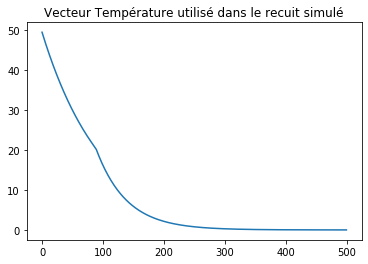

In [13]:
dim_matrice=50

T1=[dim_matrice*0.99**i for i in range(1,90)]
T2=[dim_matrice*0.98**i for i in range(45,10*dim_matrice+1-45)]
T=T1+T2

plt.plot(T)
plt.title('Vecteur Température utilisé dans le recuit simulé')

Les fonctions $J_1$,$J_2$ et $J_4$ sont de simples calculs de distances:

In [14]:
################# PREREQUIS #################

#liste des aretes du graph:
def connect(A):
    res=[]
    for i in range(n-1):
        for j in range(i+1,n):
            if(A[i,j]!=0):
                res.append([i,j])
    return res

#fonction distance point-segment.
#Retourne le projeté orthogonal si celui ci appartient au segment
#sinon retourne l'extrémité la plus proche du point:
def distance_point_seg(A, B, P):
    if all(A == P) or all(B == P):
        return 0
    if arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > pi / 2:
        return norm(P - A)
    if arccos(dot((P - B) / norm(P - B), (A - B) / norm(A - B))) > pi / 2:
        return norm(P - B)
    return norm(cross(A-B, A-P))/norm(B-A)

###################### FONCTION J1 ######################
def J1(X,Y):
    res=0
    for i in range(n-1):
        for j in range(i+1,n):
            res=res+1/((X[i]-X[j])**2+(Y[i]-Y[j])**2)  
    return res


###################### FONCTION J2 ######################
def J2(X,Y):
    res=0
    for i,j in connected:
        res=res+(X[i]-X[j])**2+(Y[i]-Y[j])**2
    return res
        
    
###################### FONCTION J4 ######################
def J4(X,Y):
    S=0
    for i,j in connected:
        for k in range(n):
            if (k!=j and k!=i):
                #pour eviter des valeurs infiniment grandes, quand un point est
                #tres proche d'une arete on lui attribut une distance de 0.0001
                d=max(distance_point_seg(np.array([X[i],Y[i]]),
                                   np.array([X[j],Y[j]]),
                                   np.array([X[k],Y[k]])),0.0001)
                S=S+1/d
    return(S)


La fonction $J_3$ est plus compliquée:

In [15]:
#calcul d'un déterminant entre 2 points:
def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

#Notre fonction croisement
def croisement(line1,line2):
    #On commence par chercher l'intersection des deux droites
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    div = det(xdiff, ydiff)
    if (div == 0):
        res=[]
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    res=[x,y]
        
    #Vérifie si l'intersection appartient aux 2 aretes et retourne 1 dans ce cas:
    if(res!=[]
       and line1[0]!=line2[0]
       and line1[0]!=line2[1]
       and line1[1]!=line2[0]
       and line1[1]!=line2[1]
       and res[0]<= max(line1[0][0],line1[1][0]) 
       and res[0]>= min(line1[0][0],line1[1][0]) 
       and res[0]<= max(line2[0][0],line2[1][0]) 
       and res[0]>= min(line2[0][0],line2[1][0])):
        return(1)
    else:
        return(0)

###################### FONCTION J3 ######################
def J3(X,Y):
    compt=0
    c=0
    pos=0
    for i,k in connected[:-1]:
        pos=pos+1
        for j,l in connected[pos:]:
            if(j!=i and l!=k):
                c=croisement(([X[i],Y[i]],[X[k],Y[k]]),([X[j],Y[j]],[X[l],Y[l]]))
                compt=compt+c
    return compt



In [16]:
###################### FONCTION J ######################

def J(X,Y):
    return J1(X,Y)*J2(X,Y)*(J3(X,Y)+1)

In [8]:
############## RECUIT SIMULE ####################

#algorithme de recuit simulé simple (changer 1 point à la fois) 

def RS_simple(T,A,a,max_try):
    
    it=0
    tentatives=0
    X=npr.uniform(0,1,n)+0
    Y=npr.uniform(0,1,n)+0
    Etat1=J(X,Y)

    while (it<(len(T)-1)):

        k=npr.choice(n,1)#on tire 1 indice
        it_precedent=it
        
            
        X_increment=npr.uniform(-a,a)
        Y_increment=npr.uniform(-a,a)
        
        X_temp=X+0
        X_temp[k]=X_temp[k]+X_increment+0
        Y_temp=Y+0
        Y_temp[k]=Y_temp[k]+Y_increment+0
        
        Etat2=J(X_temp,Y_temp)

        if(((Etat2<Etat1))
            and (0<X_temp[k]<1)
            and (0<Y_temp[k]<1)):
            X=X_temp+0
            Y=Y_temp+0
            Etat1=Etat2
            it=it+1
            if(it%len(A)==0):
                print(str(round(100*it/(len(T))))+'%')
            
        else: 
            U=npr.uniform(0,1)
            if((U<np.exp(Etat1-Etat2)/T[it+1])
               and (0<X_temp[k]<1)
               and (0<Y_temp[k]<1)):
                
                X=X_temp+0
                Y=Y_temp+0
                Etat1=Etat2
                it=it+1
                if(it%len(A)==0):
                    print(str(round(100*it/(len(T))))+'%')
        
        if(it==it_precedent):
            tentatives=tentatives+1
            if(T[it]<10**-4):
                break
        else:
            tentatives=0
            
        if (tentatives>max_try):
            it=it+1
            tentatives=0
            
    return(X,Y)

### Fonction qui exécute le recuit simulé et trace le graphe
def Recuit_graph(A,max_try=50):
    global n
    global connected
    #on créé ces variables globalement pour ne pas 
    #avoir à les recreer dans chaque J (gain de temps)
    n=len(A)
    connected=connect(A)

    N=max(10*n,300)
    #loi des incréments : Uniforme (-a,a) 
    a=0.35

    #Vecteur des températures
    T1=[n*0.99**i for i in range(1,90)]
    T2=[n*0.98**i for i in range(45,N+1-45)]
    T=T1+T2
    
    global OPTI
    #on rend cette variable globale
    #pour pouvoir réutiliser X et Y dans la fonction de recherche aléatoire optiJ4()
    OPTI=RS_simple(T,A,a,max_try)
    
    plot_graph(OPTI[0],OPTI[1], A)
    plt.show()
    print('Nombre de croisements:'+str(J3(OPTI[0],OPTI[1])))
    print('Energie totale du système:'+str(J(OPTI[0],OPTI[1])) )
    return(J(OPTI[0],OPTI[1]))



#on optimise J4 par recherche localisée (écarter un peu les points des aretes)
def optiJ4(A):
    global n
    n=len(A)
    X_opti=OPTI[0]
    Y_opti=OPTI[1]
    u=2/n
    Etat1=J4(X_opti,Y_opti)*(1+J3(X_opti,Y_opti)) #on multiplie par J3 pour éviter les croisements
    for iteration in range(10*n):
        X=X_opti+0
        Y=Y_opti+0
        k=npr.choice(n,1)
        X[k] = X[k] + npr.uniform(-u,u,len(k))
        Y[k] = Y[k] + npr.uniform(-u,u,len(k))
        Etat2=J4(X,Y)*(J3(X,Y)+1)
        if(iteration%n ==0):
              print(str(round(100*iteration/(n*10),1))+'%')
        if (Etat2<Etat1):
            Etat1=Etat2
            X_opti=X+0
            Y_opti=Y+0

    plot_graph(X_opti,Y_opti, A)
    plt.show()
    


C'est ici que vous pouvez lancer l'algorithme en tappant simplement "Recuit_graph(A,max_try)" où A est une matrice d'adjacence. "max_try" est le nombre d'essai avant de forcer à baisser la température d'un cran. Vous pouvez simplement écrire "Recuit_graph(A)" et "max_try" sera 50 par défaut.

On a essayé de rendre l'algorithme assez rapide au détriment des performances. Pour avoir de meilleurs résultats avec les grosses matrices ( A4 par exemple ), il faut monter la variable "max_try=100" dans l'algorithme. (Mais il faudra environ 20~30min pour A4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp


10%
20%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars


60%
80%
90%


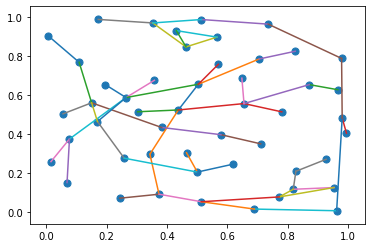

Nombre de croisements:5
Energie totale du système:
--- 90.0328299999237 seconds ---


In [17]:
import time
start_time = time.time()
Recuit_graph(A3,30)
print("--- %s seconds ---" % (time.time() - start_time))


Optimisation de $J_4$ par recherche aléatoire localisée (si nécessaire):

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


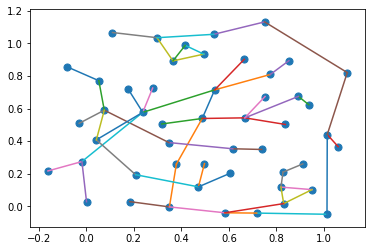

In [18]:
#OPTIMISATION DE J4 (si besoin pour decoller les points des aretes)
#à exécuter apres Recuit_graph 
#ne pas oublier de mettre en argument la même matrice.
optiJ4(A3)